In [1]:
import sys

sys.path.append('..')

In [2]:
import numpy as np
from utility import LinearDataGenerator2D
from utility import generate_samples_with_uncertainty
from utility import select_random_data_partition
from utility import fit_regression_model
from utility import regressor_prediction

In [3]:
import matplotlib.pyplot as plt 

### Data generator
linear data generator produces simulated data with a linear trend and noise

In [4]:
generator_fn = LinearDataGenerator2D(slope=1., intercept=0.)

### Adjust the parameters below to generate new datasets

In [5]:
number_of_samples=15
result = generate_samples_with_uncertainty(number_of_samples=number_of_samples,
                                           base_function=generator_fn,
                                           uncertainty=2.5,
                                           seed=42)

In [6]:
xy_true = result['true_observation']
xy_observed = result['noisy_observation']

### Random sampling
Number of random samples to be selected from the dataset can be specified in a comma-separated manner below 

In [7]:
partitions = select_random_data_partition(number_of_samples, [3, 4, 5, 10], seed=121)
models = list()

for part in partitions:
    x_, y_ = xy_observed[part, :1], xy_observed[part, 1]
    reg = fit_regression_model(x_, y_, model_type='lasso') #alternatively use sgd-regressor
    models.append(reg)

In [8]:
predictions = []
x = xy_observed[:, :1]
for model in models:
    predictions.append( np.concatenate([x, regressor_prediction(model, x)[..., np.newaxis]], axis=1))

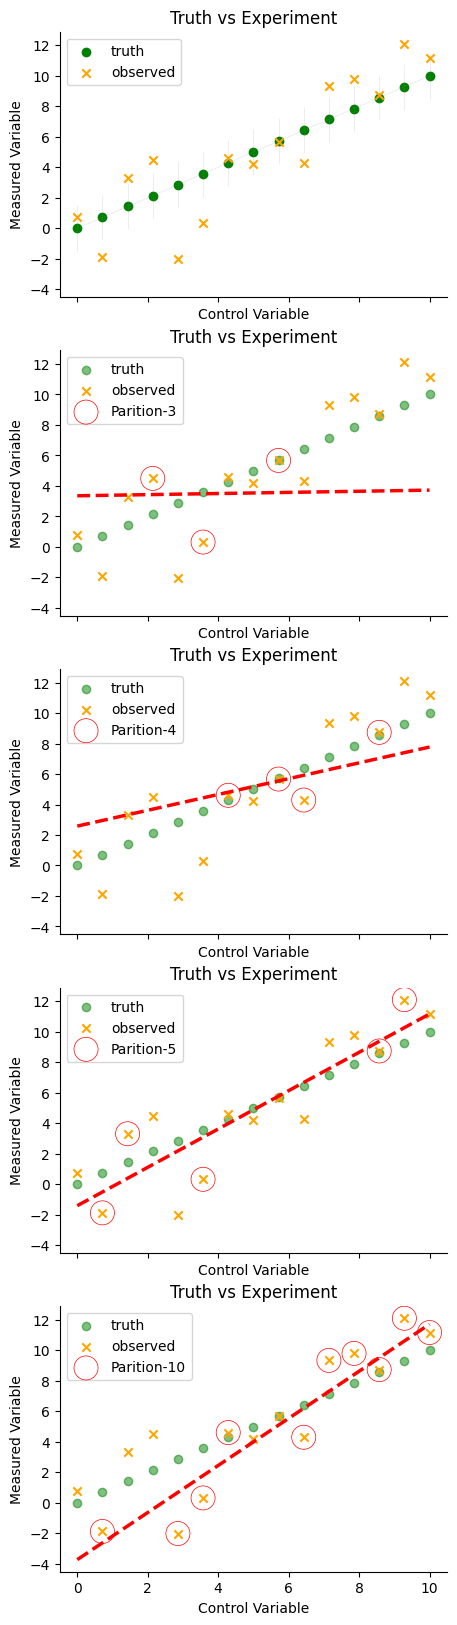

In [9]:
fig, axs = plt.subplots(1+len(partitions), 1, sharey='col', sharex='col', figsize=(5, 20))
axs[0].scatter(xy_true[:, 0], xy_true[:, 1], marker='o', color='green', label='truth')
axs[0].scatter(xy_observed[:, 0], xy_observed[:, 1], marker='x', color='orange', label='observed')
axs[0].legend()
axs[0].errorbar(xy_true[:, 0], xy_true[:, 1], yerr=1.5, linewidth=0.5, color='gray', alpha=0.2)

for i, part in enumerate(partitions):
    axs[1+i].scatter(xy_true[:, 0], xy_true[:, 1], marker='o', color='green', label='truth', alpha=0.5)
    axs[1+i].scatter(xy_observed[:, 0], xy_observed[:, 1], marker='x', color='orange', label='observed')
    axs[1 + i].scatter(xy_observed[part, 0], 
                   xy_observed[part, 1], 
                   marker='o', 
                   s=300,
                   color='red', 
                   label=f'Parition-{len(part)}',
                   linewidth=0.5,
                   facecolor='none')
    axs[1+i].plot(predictions[i][:, 0],
                  predictions[i][:, 1],
                  color='red',
                  linewidth=2.5,
                  linestyle='dashed')
    axs[1 + i].legend()

for ax in axs.flat:
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    ax.set_title(f'Truth vs Experiment', fontsize=12)
    ax.set_xlabel(f'Control Variable')
    ax.set_ylabel(f'Measured Variable')
plt.show()

### MC sampling to estimate the associated uncertainty with small sample vs. large sample
As n_experiments is increased the associated uncertainty decreases. This underscores the need for better modeling strategies with small number of experiments 

In [10]:
n_experiments = 50
batch_sizes = [3, 4, 5,10]
uq_measure = list()
for i in range(n_experiments):
    partitions = select_random_data_partition(number_of_samples, batch_sizes, seed=None)
    model_errors = list()
    for part in partitions:
        x_, y_ = xy_observed[part, :1], xy_observed[part, 1]
        reg = fit_regression_model(x_, y_, model_type='lasso') #alternatively use sgd-regressor
        predicted = reg.predict(xy_observed[:, :1])
        errors = np.mean(np.square(predicted - xy_observed[:, 1]))
        model_errors.append(errors)
    uq_measure.append(model_errors)
    
        
        

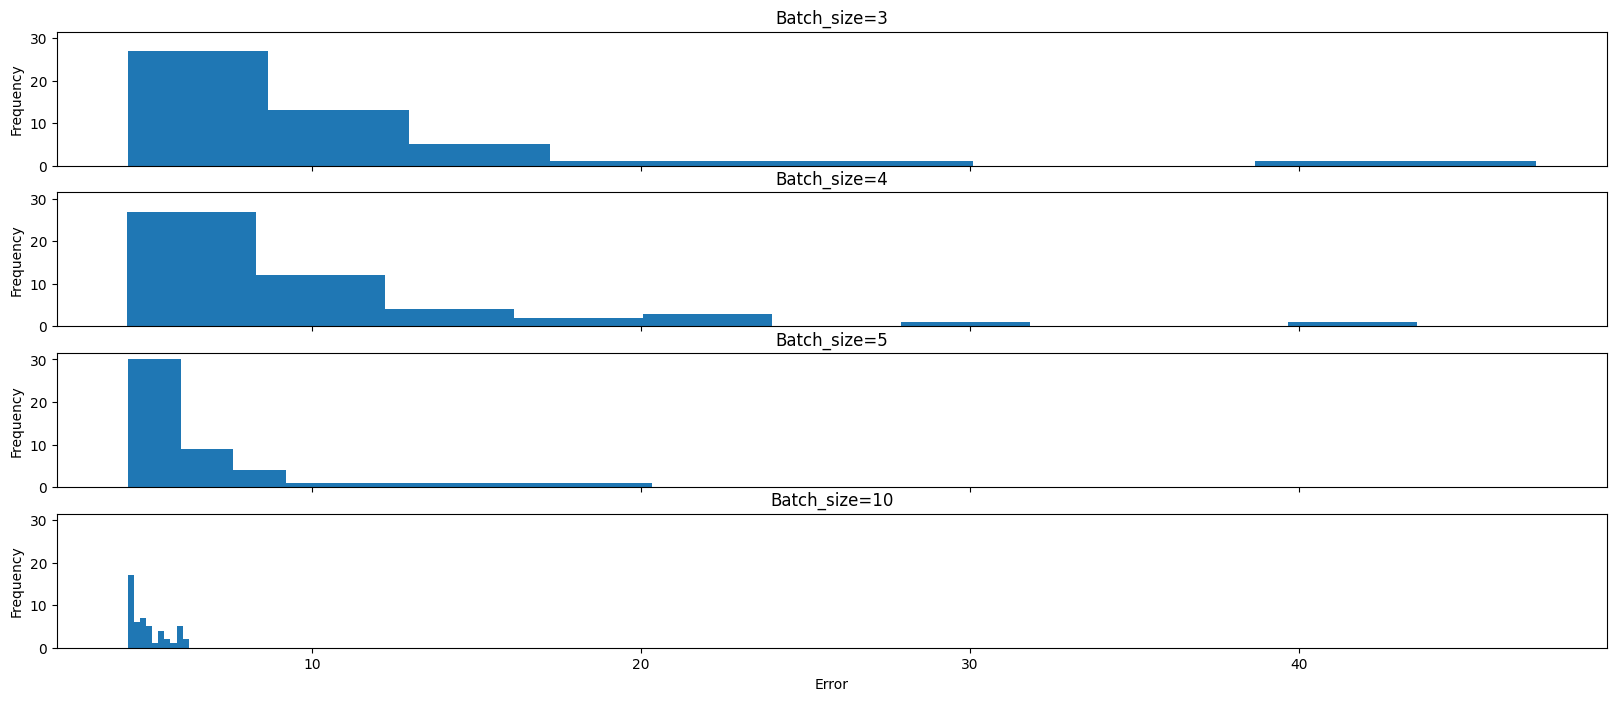

In [11]:
fig , axs = plt.subplots(len(batch_sizes),1, sharex='col', sharey=True, figsize=(20,8))
for i,b in enumerate(batch_sizes):
    axs[i].hist(np.array(uq_measure)[:,i])
    axs[i].set_title(f'Batch_size={b}')
    axs[i].set_ylabel(f'Frequency')
    if i==len(batch_sizes)-1:
        axs[i].set_xlabel(f'Error')
    